In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import keras

import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K

2025-10-16 11:31:09.961664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# TODO: defined helper functions here

def load_data(data):
    """
    load traces, plaintexts and keys from the dataset
    
    """

    trace_idx = data.files[0]
    traces = data[trace_idx]

    plaintext_idx = data.files[1]
    plaintexts = data[plaintext_idx]

    key_idx = data.files[2]
    keys = data[key_idx]

    return traces, plaintexts, keys


def calculate_HW(data):
  """
  convert labels (sbox ouput values) to HW

  """
  hw = [bin(x).count("1") for x in range(256)]
  return [hw[int(s)] for s in data]


def prep_data(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = the leakage model of the target intermediate value

    returns a dictionary of the form
       'label_value': list of traces associated with 'label_value'
    """

    labels = np.unique(labels_set)  
    dictionary = {int(label): [] for label in labels}

    for count, label in enumerate(labels_set):
        dictionary[int(label)].append(trace_set[count])

    return dictionary


def snr_trace(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = a set of labels of the same lenght as trace_set

    returns a dictionary of the form
       'label_value': mean_sample trace with 'label_value'
    """
    mean_trace = {}
    signal_trace = []
    noise_trace = []

    labels = np.unique(labels_set) # determine the set of unique values for the leakage model - for HW, labels = {0, 1, 2, 3, 4, 5, 6, 7}, for ID, labels = {0, 1, 2,... 255}
    grouped_traces = prep_data(trace_set, labels_set) # group the traces together that share the same label

    #compute the mean trace (the same are the signal traces)
    for label in labels:                                                # for each label (HW value or ID value)
        mean_trace[label] = np.mean(grouped_traces[label], axis=0)            # calculate signal - the mean of traces that share the same label 
        signal_trace.append(mean_trace[label])                          

    #compute the noise trace
    for label in labels:                                                # for each label (HW value or ID value)
        for trace in grouped_traces[label]:                                   # for all traces with the same label (HW value)
            noise_trace.append(trace-mean_trace[label])                             # calculate noise - trace - mean

    var_noise = np.var(noise_trace, axis=0)                     # calculate var(noise)
    var_signal = np.var(signal_trace, axis=0)                   # calculate var(signal)
    snr_trace = var_signal/var_noise                            # calculate snr = var(signal)/var(noise)

    return snr_trace


def points_of_interets(snrs, nrp = 50):
    """
    return top nrp snr values

    """
    return np.argsort(snrs)[::-1][:nrp]


In [3]:
# AES Sbox function

AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])

In [4]:
import os
os.listdir("data/CW_dataset/CW_dataset/CW_seeded")

['.DS_Store', 'ML_train', 'ML_test']

In [5]:
# load and explore the dataset

file_path_train = "data/CW_dataset/CW_dataset/CW_seeded/ML_train/device_A/dataset_device_A.npy"
data_train = np.load(file_path_train)

file_path_test = "data/CW_dataset/CW_dataset/CW_seeded/ML_test/device_A/dataset_device_A.npy"
data_test = np.load(file_path_test)

# print(data_train.files)
# print(data_test.files)

In [6]:
# load train set

traces_train, plaintexts_train, keys_train = load_data(data_train)
print(traces_train.shape)

(50000, 12000)


In [7]:
# laod test set

traces_test, plaintexts_test, keys_test = load_data(data_test)
print(traces_test.shape)

(10000, 12000)


In [5]:
# print("KEYS")
# print(X_keys_train.shape)
# print(X_keys_test.shape)
# print('\n')

# print("TEXTS")
# print(X_plaintext_train.shape)
# print(X_plaintext_test.shape)
# print('\n')

# print("TRACES")
# print(X_traces_train.shape)
# print(X_traces_test.shape)

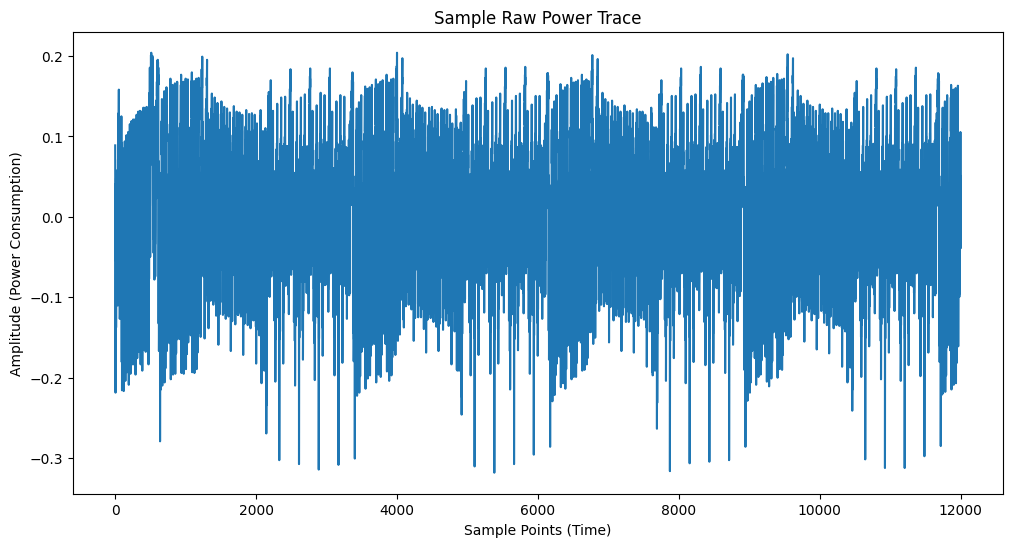

In [8]:
# visualize one trace

idx = 0

plt.figure(figsize=(12, 6))
plt.plot(traces_train[idx])
plt.title(f"Sample Raw Power Trace")
plt.xlabel("Sample Points (Time)")
plt.ylabel("Amplitude (Power Consumption)")
plt.show()

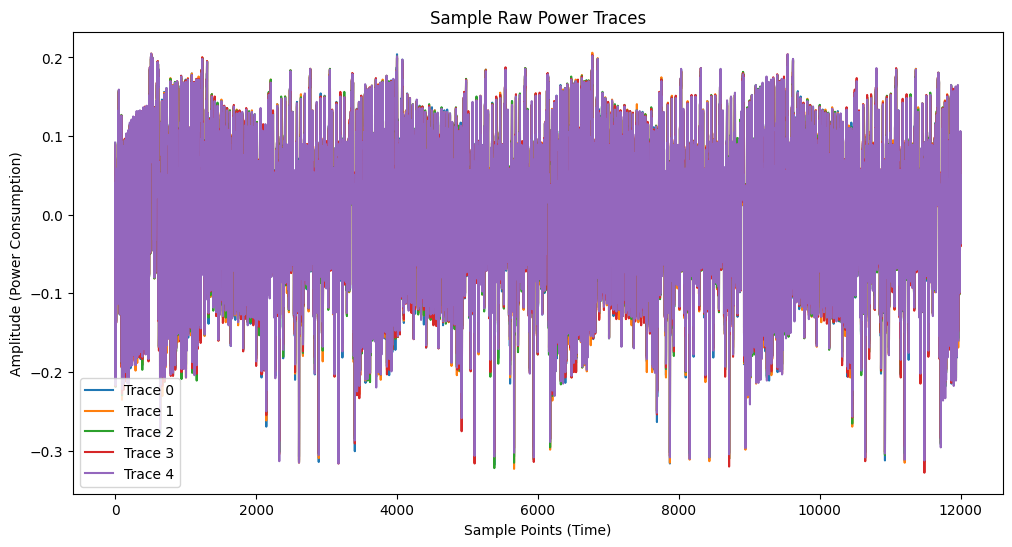

In [9]:
# visualize multiple traces

num_traces_to_plot = 5

plt.figure(figsize=(12, 6))

for i in range(num_traces_to_plot):
    plt.plot(traces_train[i], label=f"Trace {i}")

plt.title("Sample Raw Power Traces")
plt.xlabel("Sample Points (Time)")
plt.ylabel("Amplitude (Power Consumption)")
plt.legend()
plt.show()

In [ ]:
# standardize the raw tarces

scaler = StandardScaler() 
traces_train = scaler.fit_transform(traces_train)
traces_test = scaler.transform(traces_test)


In [11]:
# create labels - AES-sbox(plaintext xor key) - for a particular target byte

def create_labels(ptxt_train, keys_train, ptxt_test, keys_test, target_byte = 0):
    y_train = AES_Sbox[ptxt_train[:, target_byte] ^ keys_train[:, target_byte]]
    y_test = AES_Sbox[ptxt_test[:, target_byte] ^ keys_test[:, target_byte]]
    return y_train, y_test

y_train, y_test = create_labels(plaintexts_train, keys_train, plaintexts_test, keys_test)

# print(y_train.shape)
# print(y_train[:5])

In [12]:
# define a leakag model for feature selection, and select refined POIs with SNR measure

leakage_model = 'HW' # or 'ID' (ID gives 256 classes, HW gives 9 classes)

if leakage_model == 'HW':
  y_train = calculate_HW(y_train) 
  y_test = calculate_HW(y_test)

# print(len(y_train))
# print(y_train[:5])

In [13]:
print(traces_train[:1000].shape)
print(traces_test.shape)

(1000, 12000)
(10000, 12000)


In [14]:
# select features on train set
# traces_train.shape = (50'000, 1200)

n = 20000 # for now I calculate the snr values based on the 1st 3000 traces, as my computer cannot compute more...
traces_train_subset = traces_train[:n]
y_train_subset = y_train[:n]

snr_values_train = snr_trace(traces_train_subset, y_train_subset)
pois_train = points_of_interets(snr_values_train)
selected_features_train = traces_train[:, pois_train]

print(traces_train_subset.shape)
print(selected_features_train.shape)

(20000, 12000)
(50000, 50)


In [19]:
# select a window of traces

x = 1320
size = 50

selected_window_train = traces_train[:, x-size:x+size]
selected_window_test = traces_test[:, x-size:x+size]

print(selected_window_train.shape)
print(selected_window_test.shape)

(50000, 100)
(10000, 100)


In [16]:
# select features on test set
# traces_test.shape = (10'000, 1200)

snr_values_test = snr_trace(traces_test, y_test)
pois_test = points_of_interets(snr_values_test)
selected_features_test = traces_test[:, pois_test]

print(traces_test.shape)
print(selected_features_test.shape)

(10000, 12000)
(10000, 50)


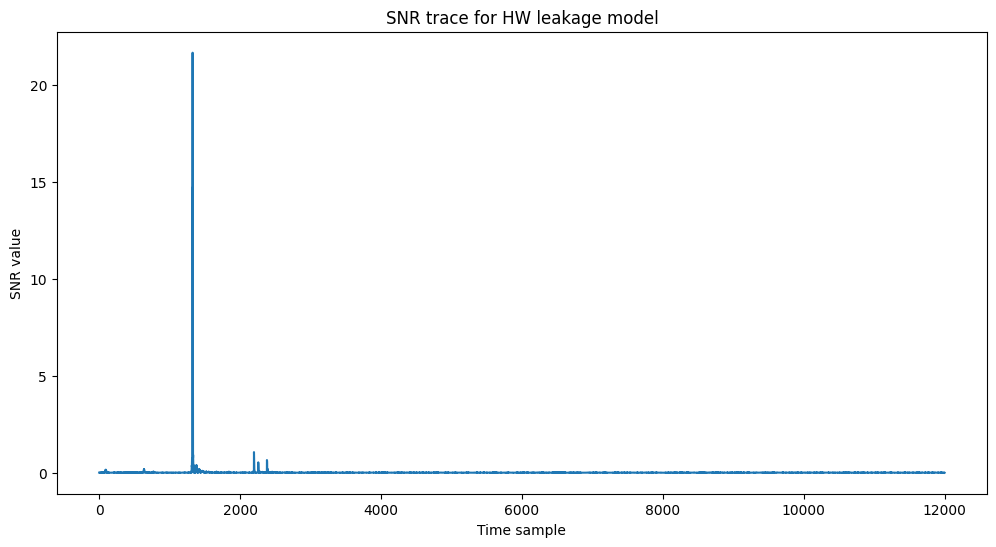

In [17]:
# plot SNR trace for HW leakage model

plt.figure(figsize=(12,6))
plt.plot(snr_values_train)
plt.title("SNR trace for HW leakage model")
plt.xlabel('Time sample')
plt.ylabel('SNR value')
plt.show()

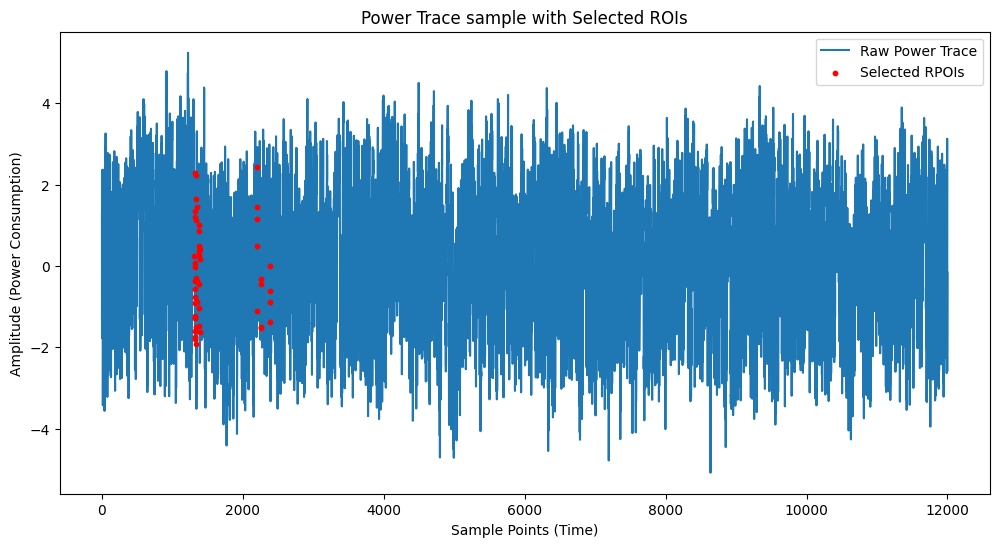

In [18]:
# plot selected POIs over a raw power traces

trace_idx = 0
trace = traces_train[trace_idx]

plt.figure(figsize=(12, 6))
plt.plot(trace, label="Raw Power Trace", zorder=1)

# Use pois_train for indices, not selected_features_train[0]
plt.scatter(pois_train, trace[pois_train],
            color="red", marker="o", s=10, label="Selected RPOIs", zorder=2)

plt.title("Power Trace sample with Selected ROIs")
plt.xlabel("Sample Points (Time)")
plt.ylabel("Amplitude (Power Consumption)")
plt.legend()
# plt.show()

plt.savefig("raw-trace-w-selected-points.pdf")



In [20]:
# choose a leakage model for the neural netwrok, and prepare the labels

leakage_model = 'ID' # or 'HW' (ID gives 256 classes, HW gives 9 classes)

if leakage_model == 'HW':
  nb_classes = 9
elif leakage_model == 'ID':
  nb_classes = 256

# convert the labels
# y_train = to_categorical(y_train[:3000], num_classes=nb_classes)
y_train = to_categorical(y_train, num_classes=nb_classes)
y_test = to_categorical(y_test, num_classes=nb_classes)

# RPOI selection (pass only points)
# X_train = selected_features_train
# X_test = selected_features_test


# OPOI selection - pass a range of points
X_train = selected_features_train
X_test = selected_window_test

In [21]:
print(y_train.shape)
print(y_test.shape)

print(y_train[:5])

(50000, 256)
(10000, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# # simple MLP model - PyTorch

# class MLP(nn.Module):
#     def __init__(self, input_dim, num_classes):
#         super(MLP, self).__init__()
#         torch.manual_seed(917539)  # for reproducibility

#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 500),
#             nn.ReLU(),
#             nn.Linear(500, 500),
#             nn.ReLU(),
#             nn.Linear(500, num_classes),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         return self.net(x)


# def mlp(classes, number_of_samples):
#     batch_size = 100
#     model = MLP(input_dim=number_of_samples, num_classes=classes)
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)
#     criterion = nn.CrossEntropyLoss()

#     return model, optimizer, criterion, batch_size


In [1]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# batch_size = 100
# input_size = len(X_train[0])

# # prepare the dataset
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # assumes labels are integers (not one-hot)

# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # train setup
# nb_epochs = 100
# model, optimizer, criterion, batch_size = mlp(nb_classes, input_size)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # train loop
# for epoch in range(nb_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for batch_x, batch_y in train_loader:
#         batch_x, batch_y = batch_x.to(device), batch_y.to(device)

#         optimizer.zero_grad()
#         outputs = model(batch_x)
#         loss = criterion(outputs.argmax(dim=-1), batch_y)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * batch_x.size(0)
#         _, predicted = torch.max(outputs, 1)
#         total += batch_y.size(0)
#         correct += (predicted == batch_y).sum().item()

#     epoch_loss = running_loss / len(train_dataset)
#     epoch_acc = correct / total

#     print(f"Epoch [{epoch+1}/{nb_epochs}]  Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc:.4f}")


In [24]:
# Model taked from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.

def mlp(classes, number_of_samples):

    batch_size = 100
    tf.random.set_seed(917539)
    model = Sequential(name="mlp")
    model.add(Dense(500, activation = "relu", kernel_initializer = "he_uniform", input_shape = (number_of_samples,)))
    model.add(Dense(500, activation = "relu", kernel_initializer = "he_uniform"))
    model.add(Dense(classes, activation = "softmax"))
    model.summary()
    optimizer = Adam(learning_rate = 0.0001)
    model.compile(loss="categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

    return model, batch_size

In [20]:
# train the model

nb_epochs = 100
input_size = len(X_train[0])

model, batch_size = mlp(nb_classes, input_size)
history = model.fit(x=X_train, y=y_train, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

/home/bbertule/Documents/thesis/notebooks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-01 10:57:40.721360: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 500)            │        25,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       128,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,256 (1.54 MB)

 Trainable params: 404,256 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2630 - loss: 2.4845
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2814 - loss: 1.7313
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3197 - loss: 1.6484
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4290 - loss: 1.5044
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4871 - loss: 1.3532
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5292 - loss: 1.2265
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5663 - loss: 1.1217
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5973 - loss: 1.0343
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6217 - loss: 0.9616
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6472 - loss: 0.9010
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6674 - loss: 0.8506
Epoch 12/100
500/500 ━━━━━━━━━━━━━━━━━━━━

In [21]:
# save the model

model.save("mlp_model.keras")

In [25]:
# load the model

model = keras.models.load_model("mlp_model.keras")  # or .keras

2025-10-16 11:57:28.808182: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [26]:
# attack, make predictions of the intermediate value

predictions = model.predict(selected_features_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [32]:
print(predictions.shape)
print(len(predictions[0]))
print(predictions[0][:5])
# print(predictions[0][np.argwhere(predictions[0] != 0)])

(10000, 256)
256
[0.99999994 0.         0.         0.         0.        ]


In [25]:
# TODO
# key rank

"""

"""


# guessing entropy

# Functions to calculate GE for a given number of attack traces
def score_keys(predictions, plaintexts):
  """
  Computes the scores for each key hypothesis
  """
  scores_keys = np.zeros(256)
  for k in range(256):
    #Generate Hypothetical labels for a key candidate k
    hypothetical_labels = AES_Sbox[plaintexts ^ k]
    if leakage_model == "HW":
      hypothetical_labels = calculate_HW(hypothetical_labels)

    for i in range(predictions.shape[0]):
      scores_keys[k] += predictions[i, hypothetical_labels[i]]
  return scores_keys

def guessing_entropy(predictions, plaintexts, correct_key, nb_traces, nb_attacks=100):
  ranks = np.zeros(nb_attacks) 
  # Take log of probablities to sum later with small addition for numeric stability
  predictions_log = np.log(predictions + 1e-36)

  for attack in range(nb_attacks):
    # Take random subset of traces
    r = np.random.choice(
            range(predictions_log.shape[0]), nb_traces, replace=False)

    key_scores = score_keys(predictions_log[r], plaintexts[r])

    order_keys = np.argsort(key_scores)[::-1]

    ranks[attack] = np.where(order_keys == correct_key)[0][0]
  return np.median(ranks), np.average(ranks)

In [26]:
target_byte = 0

correct_key = keys_test[0, target_byte] # 0 because it is fixed key so we just get the first in the array
print(correct_key)

# print(plaintexts_test.shape)
median_ge, avg_ge = guessing_entropy(predictions, plaintexts_test[:, target_byte], correct_key, nb_traces=10000)
print(f"GE using median is {median_ge}, while using average, GE is {avg_ge}.")


43


In [27]:
print(f"GE using median is {median_ge}, while using average, GE is {avg_ge}.")

GE using median is 255.0, while using average, GE is 255.0.
